<a href="https://colab.research.google.com/github/KillerStrike17/Learn_With_Shubham/blob/master/Talks/Types%20of%20Regularization/Types_of_Regularization_Techniques_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Feb  6 11:02:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Importing Libraries

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, Flatten, Conv2D, GlobalAveragePooling2D,MaxPool2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from  tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

TensorFlow 2.x selected.


# Loading Dataset

In [3]:
#splitting the database
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

#Storing the training dataset details in variables
num_train,  img_rows, img_cols,img_channels, =  train_features.shape
print("No of training dataset:- ",num_train)
print("No of rows:- ",img_rows)
print("No of columns:- ",img_cols)
print("No of channels:- ",img_channels)

#Storing the testing dataset details in variables
num_test, _, _, _ =  test_features.shape

#Stroing the total class of dataset in num_classes variable
num_classes = len(np.unique(train_labels))
print("Total Classes:- ", num_classes)

170500096/170498071 [==============================] - 2s 0us/step
No of training dataset:-  50000
No of rows:-  32
No of columns:-  32
No of channels:-  3
Total Classes:-  10


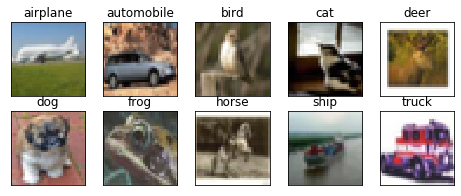

In [4]:
#class_names of the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
#loop to display a sample image of each channel
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#converting the pixel in range 0-1
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Helper Functions

In [0]:

#function to plot graphs of accuracy and loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def show_examples(X, y_ohe, classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y_ohe[idx])])
    plt.show()

def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [0]:
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True):
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img

    return eraser
  
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

# Model

Cutouts, FlipLR and Rotation

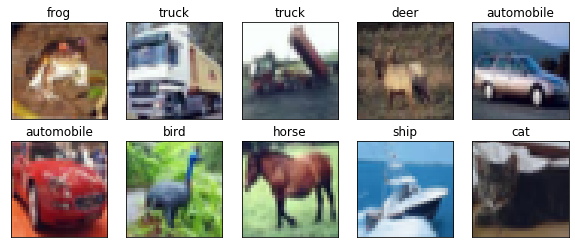

In [9]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
datagen.fit(train_features)
train_iterator = datagen.flow(train_features, train_labels, batch_size=100,shuffle=False)

X, Y = train_iterator.next()
X = min_max_scale(X)
show_examples(X[0:10], Y[0:10], classes = get_cifar10_labels())

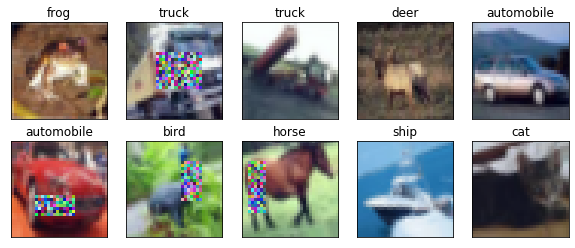

In [10]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip =True,rotation_range = 20,
                             preprocessing_function=get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, 
                                                                      max_erasures_per_image=1, pixel_level=True))
datagen.fit(train_features)
train_iterator = datagen.flow(train_features, train_labels, batch_size=256,shuffle=False)
validation_iterator = datagen.flow(test_features, test_labels, batch_size=256,shuffle=False)

X, Y = train_iterator.next()
X = min_max_scale(X)
show_examples(X[0:10], Y[0:10], classes = get_cifar10_labels())

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (1, 1), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (1, 1), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(Conv2D(10, (1, 1), activation = 'relu'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        2080      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        3

In [0]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc'])

# Training and Results

In [13]:
history = model.fit_generator(train_iterator,
                      steps_per_epoch=len(train_iterator), 
                      validation_data = validation_iterator, 
                      validation_steps = len(validation_iterator),
                      epochs=20, verbose=1)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 196 steps, validate for 40 steps
Epoch 1/20
196/196 [==============================] - 38s 192ms/step - loss: 1.9347 - acc: 0.3024 - val_loss: 1.6246 - val_acc: 0.3994
Epoch 2/20
196/196 [==============================] - 32s 161ms/step - loss: 1.5009 - acc: 0.4491 - val_loss: 1.3904 - val_acc: 0.4855
Epoch 3/20
196/196 [==============================] - 30s 154ms/step - loss: 1.3301 - acc: 0.5174 - val_loss: 1.3525 - val_acc: 0.4997
Epoch 4/20
196/196 [==============================] - 30s 154ms/step - loss: 1.2419 - acc: 0.5509 - val_loss: 1.1764 - val_acc: 0.5775
Epoch 5/20
196/196 [==============================] - 30s 152ms/step - loss: 1.1504 - acc: 0.5853 - val_loss: 1.1401 - val_acc: 0.5933
Epoch 6/20
196/196 [==============================] - 30s 152ms/step - loss: 1.0838 - acc: 0.6125 - val_loss: 1.0527 - val_acc: 0.6244
Epoch 7/20
196/196 [=

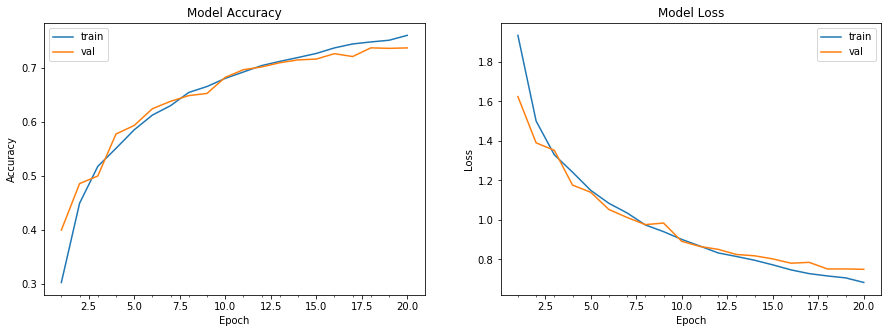

In [14]:
plot_model_history(history)